# Introduction

Our input is the resulting dataset from the Exploratory Data Analysis and the Feature Engineering performed on any original datasets. <br/>

## Imports

In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

In [3]:
# File system manangement
import os

In [4]:
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
# prepare data
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
# models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import KFold

In [6]:
# clean - garbage collection
import gc
gc.enable()

In [18]:
# custom functions
from ipynb.fs.full.functions import heatmap, missing_values_table, convert_types, split_show_results, show_results

In [23]:
''' warning show results to debug in functions (plot_roc_curve issue)'''

' warning show results to debug in functions (plot_roc_curve issue)'

In [8]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
# paramètres
# to display any columns
pd.options.display.max_columns = 122
sns.set(style="ticks")
sns.set_style('whitegrid')

## Read in Data 

First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan. 

In [10]:
# List files available
print(os.listdir('Data/'))

['application_test.csv', 'application_train.csv', 'application_trunc.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'Descriptions.xlsx', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [11]:
# first level
application = pd.read_csv('Data/application_trunc.csv')

# Data preparation

## Get train - test from Any applications

In [12]:
# keep training applications only
application = application[application['TARGET'].notna()]

## Train, Test split

We should not only remove Target in Test split, but also remove the SK_ID_CURR column (and move to index?)

In [40]:


def my_split(data=application, split_size=0.3):
    # drop the target from the training data
    if 'TARGET' in data:
        X_ = data.drop(columns=['TARGET'])
    else:
        X_ = data.copy()
    y_ = data['TARGET']
    # Feature names
    features = list(X_.columns)
    # Median imputation of missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit-transform training dataset
    X_ = imputer.fit_transform(X_)
    # Repeat with the scaler
    X_ = scaler.fit_transform(X_)
    # Split data into train and test set (stratify by target)
    X_train, X_test, y_train, y_test = train_test_split(
        X_,
        y_,
        stratify=y_,
        test_size=split_size,
        random_state=42)
    print('Training data shape: ', X_train.shape)
    print('Testing data shape: ', X_test.shape)
    print('Labels train data shape: ', y_train.shape)
    print('Labels test data shape: ', y_test.shape)
    return X_train, X_test, y_train, y_test, features

In [41]:
X_train, X_test, y_train, y_test, features = my_split()

Training data shape:  (215254, 254)
Testing data shape:  (92253, 254)
Labels train data shape:  (215254,)
Labels test data shape:  (92253,)


## Results

First functions is meant to be used with arguments model & root application dataset

In [236]:


def split_show_results(model, data=application, split_size=0.3):
    X_train, X_test, y_train, y_test = my_split(data=data, split_size=split_size)
    model.fit(X_train, y_train)
    results = model.predict_proba(X_test)[:, 1]
    print('Auc Score: %f' %roc_auc_score(y_test, results))
    plot_roc_curve(model, X_test, y_test)
    plt.title(str(model) + 'Roc curve')
    plt.show()

In [52]:


def show_results(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, case='case'):
    model.fit(X_train, y_train)
    results = model.predict_proba(X_test)[:, 1]
    plt.title('Failure probabilities for ' + case)
    plt.xlabel('Probabilities')
    plt.ylabel('Count')
    plt.hist(results, bins=100)
    plt.show()
    auc = roc_auc_score(y_test, results)
    plot_roc_curve(model, X_test, y_test)
    plt.title('Roc curve of ' + case)
    plt.show()
    fpr, tpr, thr = metrics.roc_curve(y_test, results)
    plt.plot(fpr, tpr, label=" auc="+str(auc))

3:80: E501 line too long (101 > 79 characters)


# Scoring

## Metric: Area Under Roc & "Damage Scoring"

First off all, accuracy (Σ True positive or negative / Σ Total) is not a relevant metric in our case, mainly due to the __class imbalance__, facing way fewer risky clients (& application rejection) than others, leading to over 90% accuracy.
The area under the ROC curve offers a more valuable metric. A model that simply guesses at random will have an ROC AUC of 0.5. Any improvement of AUC score, up to ideal 1, means the model gets to a minimal False positive rate and a maximal True positive rate.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/800px-Precisionrecall.svg.png" class="svg" alt="" width="350" height="636">

But in our case, we'll even discuss the opportunity of building our own score, based on confusion matrix interpretation (see [F-score](https://en.wikipedia.org/wiki/F1_score)) to more accurately reflect the considered "best" result for the company wich consist in a compromis between : approval of risky clients and rejection og good ones.

# Baseline

For a naive baseline, we could guess the same value for all examples on the testing set.  We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This  will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition ([random guessing on a classification task will score a 0.5](https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5)).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

## Logistic Regression Implementation

Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) and [Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do). Both of these books present the theory and also the code needed to make the models (in R and Python respectively). They both teach with the mindset that the best way to learn is by doing, and they are very effective! 

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

We will use [`LogisticRegression`from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for our first model. The only change we will make from the default model settings is to lower the [regularization parameter](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default `LogisticRegression`, but it still will set a low bar for any future models.

Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using `.fit` and then we make predictions on the testing data using `.predict_proba` (remember that we want probabilities and not a 0 or 1).

In [24]:
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C=0.0001)

Now that the model has been trained, we can use it to make predictions. We want to predict the probabilities of not paying a loan, so we use the model `predict.proba` method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

The following code makes the predictions and selects the correct column.

### raw prediction

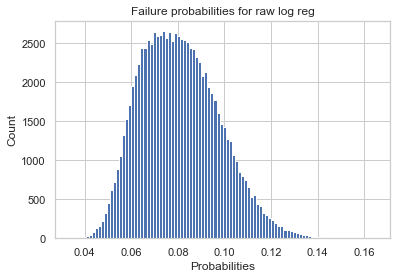

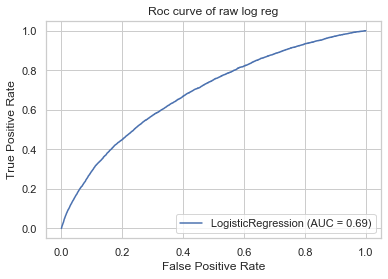

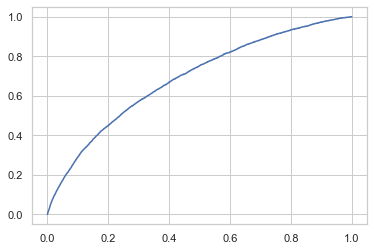

In [51]:
show_results(log_reg, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, case='raw log reg')

In [ ]:
[fpr, tpr, thr] = metrics.roc_curve(test_labels, test_pred)

### raw with class weight

In [76]:
# Make the model with the specified regularization parameter
log_reg_weight = LogisticRegression(class_weight='balanced', C=0.0001)

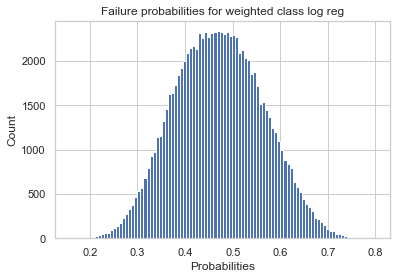

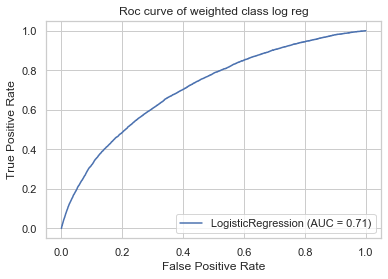

In [26]:
show_results(log_reg_weight, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, case='weighted class log reg')

## SMOTE

In [28]:
sm = SMOTE(random_state=7)

In [29]:
X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

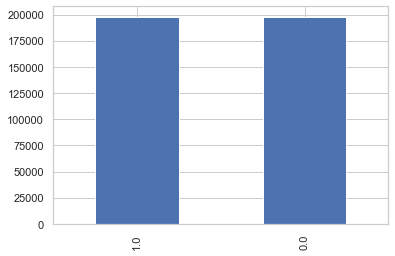

In [30]:
# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

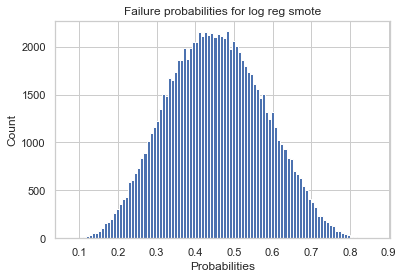

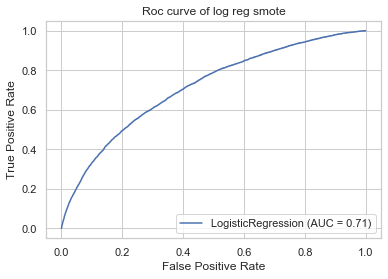

In [31]:
show_results(log_reg, X_train=X_train_new, X_test=X_test, y_train=y_train_new, y_test=y_test, case='log reg smote')

__Logistic Regression with Basic FE and Application df only score around AUC 0.69__

## Random Forest

To try and beat the poor performance of our baseline, we can update the algorithm. Let's try using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

In [33]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


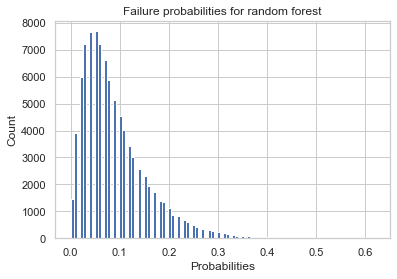

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


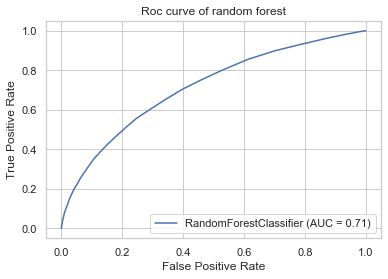

In [34]:
show_results(random_forest, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, case='random forest')

In [35]:
# Make the random forest classifier
random_forest_weight = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=50,
    verbose=1,
    n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


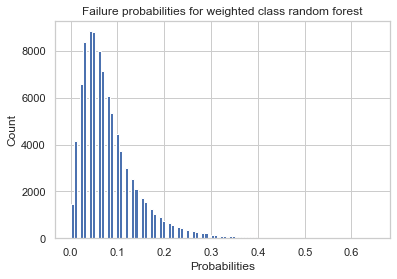

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


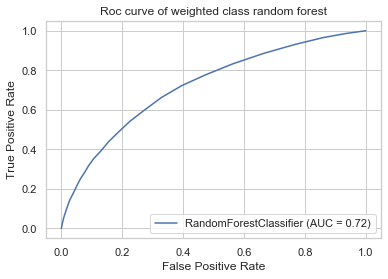

In [36]:
show_results(
    random_forest_weight,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    case='weighted class random forest')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


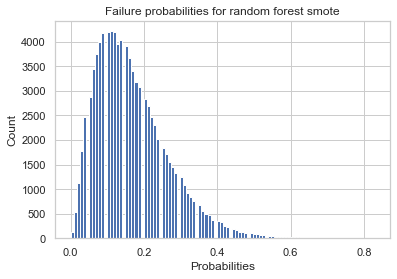

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


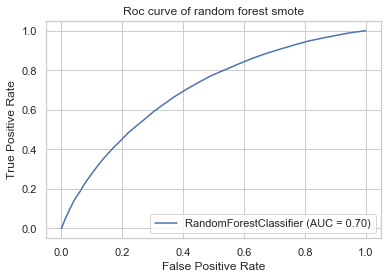

In [37]:
show_results(random_forest,
             X_train=X_train_new,
             X_test=X_test,
             y_train=y_train_new,
             y_test=y_test,
             case='random forest smote')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parall

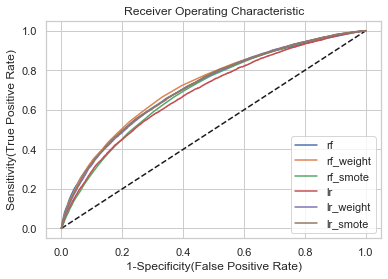

2:49: E231 missing whitespace after ','
3:5: E203 whitespace before ','
5:56: E231 missing whitespace after ','
6:5: E203 whitespace before ','
8:49: E231 missing whitespace after ','
9:5: E203 whitespace before ','
11:43: E231 missing whitespace after ','
12:5: E203 whitespace before ','
14:50: E231 missing whitespace after ','
15:5: E203 whitespace before ','
17:43: E231 missing whitespace after ','
18:5: E203 whitespace before ','
21:12: E231 missing whitespace after ','
21:15: E231 missing whitespace after ','
21:18: E231 missing whitespace after ','


In [59]:
random_forest.fit(X_train, y_train)
y_pred_1 = random_forest.predict_proba(X_test)[:,1]
fpr1 , tpr1, thr1 = roc_curve(y_test, y_pred_1)
random_forest_weight.fit(X_train, y_train)
y_pred_2 = random_forest_weight.predict_proba(X_test)[:,1]
fpr2 , tpr2, thr2 = roc_curve(y_test, y_pred_2)
random_forest.fit(X_train_new, y_train_new)
y_pred_3 = random_forest.predict_proba(X_test)[:,1]
fpr3 , tpr3, thr3 = roc_curve(y_test, y_pred_3)
log_reg.fit(X_train, y_train)
y_pred_4 = log_reg.predict_proba(X_test)[:,1]
fpr4 , tpr4, thr4 = roc_curve(y_test, y_pred_4)
log_reg_weight.fit(X_train, y_train)
y_pred_5 = log_reg_weight.predict_proba(X_test)[:,1]
fpr5 , tpr5, thr5 = roc_curve(y_test, y_pred_5)
log_reg.fit(X_train_new, y_train_new)
y_pred_6 = log_reg.predict_proba(X_test)[:,1]
fpr6 , tpr6, thr6 = roc_curve(y_test, y_pred_6)


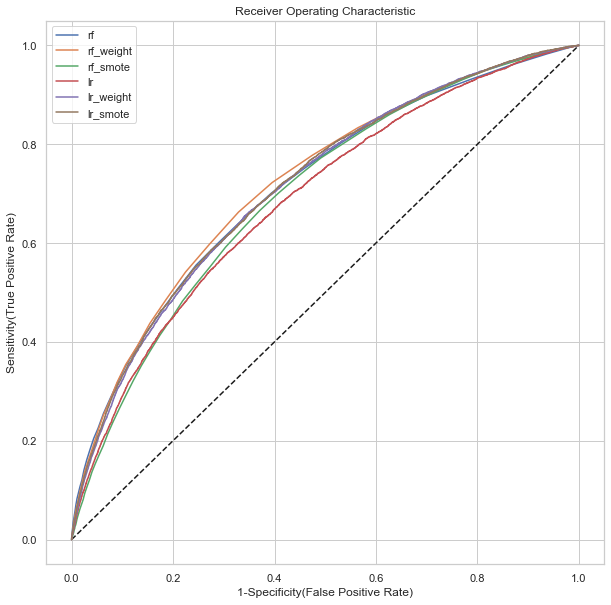

2:12: E231 missing whitespace after ','
2:15: E231 missing whitespace after ','
2:18: E231 missing whitespace after ','


In [61]:
plt.figure(figsize=(10, 10))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label="rf")
plt.plot(fpr2, tpr2, label="rf_weight")
plt.plot(fpr3, tpr3, label="rf_smote")
plt.plot(fpr4, tpr4, label="lr")
plt.plot(fpr5, tpr5, label="lr_weight")
plt.plot(fpr6, tpr6, label="lr_smote")
plt.legend()
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.show()

In [67]:
thr6

array([1.86445514, 0.86445514, 0.84018229, ..., 0.1327365 , 0.13266904,
       0.07725019])

## Features importance

In [38]:
# Train on the training data
random_forest_weight.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


NameError: name 'features' is not defined

In [42]:
# Extract feature importances
feature_importance_values = random_forest_weight.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [43]:
feature_importances

,feature,importance
0,index,0.022449
1,SK_ID_CURR,0.022543
2,NAME_CONTRACT_TYPE,0.002426
3,CODE_GENDER,0.005525
4,FLAG_OWN_CAR,0.003530
...,...,...
249,WALLSMATERIAL_MODE_Panel,0.001276
250,"WALLSMATERIAL_MODE_Stone, brick",0.001345
251,WALLSMATERIAL_MODE_Wooden,0.000305
252,EMERGENCYSTATE_MODE_No,0.001570


# Scoring

### introduce threshold

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [85]:
# define a function to make threshold adjustable
def threshold_pred(model, X, threshold=0.1):
    pred = model.predict_proba(X)
    y_pred = pred[:, 1] > threshold
    return pred, y_pred.astype(int)

In [88]:
log_reg_weight.fit(X_train, y_train)
pred, y_pred = threshold_pred(log_reg_weight, X_test, threshold=0.5)

first, we need to avoid __False Negative__ : approval of any clients with actual defaults is our worts case, predicting target 0 while actual value is 1.
then, we also wish to avoid __False Positive__ : rejecting too many clients who actually would not fail, predicting target 1 while actual value is 0.

In [91]:
# get any case of the confusion matrix
# ravel() is equivalent to flatten for arrays
(tn, fp, fn, tp) = confusion_matrix(y_test, y_pred).ravel()

In [93]:
# get the precision, recall
precision, recall, f_thresholds = precision_recall_curve(y_test, pred[:, 1])

In [184]:
print(np.count_nonzero(y_test))
print(len(y_test))

7448
92253


In [217]:
# optimal threshold
list_tn = []
list_fp = []
list_fn = []
list_tp = []
list_prec = []
list_rec = []
list_fscore = []
list_gain = []
list_custom = []
threshold_values = []

tp_coef = 0
tn_coef = 1
fn_coef = -7
fp_coef = -1

worst_case = fp_coef * np.count_nonzero(y_test) + tn_coef * (len(y_test) - np.count_nonzero(y_test))
best_case = tn_coef * (len(y_test) - np.count_nonzero(y_test))


for i in np.arange(0, 1, 0.01):
    _, temp_y_pred = threshold_pred(log_reg_weight, X_test, threshold=i)
    tn, fp, fn, tp = confusion_matrix(y_test, temp_y_pred).ravel()
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    fscore = 2 * prec * rec / (prec + rec)
    gain = tp * tp_coef + tn * tn_coef + fn * fn_coef + fp * fp_coef
    custom = (gain - worst_case) / (best_case - worst_case)
    threshold_values.append(i)
    list_tn.append(tn)
    list_fp.append(fp)
    list_fn.append(fn)
    list_tp.append(tp)
    list_prec.append(prec)
    list_rec.append(rec)
    list_fscore.append(fscore)
    list_gain.append(gain)
    list_custom.append(custom)

18:80: E501 line too long (100 > 79 characters)


In [218]:
confusion_matrix_df = pd.DataFrame({'tn': list_tn,
                                    'fp': list_fp,
                                    'fn': list_fn,
                                    'tp': list_tp},
                                   index=threshold_values)

In [224]:
confusion_matrix_df.sample(10)

,tn,fp,fn,tp
0.91,84805,0,7448,0
0.64,82574,2231,6520,928
0.41,24623,60182,686,6762
0.90,84805,0,7448,0
0.60,78676,6129,5546,1902
0.30,2423,82382,33,7415
0.78,84803,2,7446,2
0.97,84805,0,7448,0
0.43,31144,53661,967,6481
0.04,0,84805,0,7448


In [220]:
scores_df = pd.DataFrame({'precision': list_prec,
                          'recall': list_rec,
                          'f1score': list_fscore,
                          'gain': list_gain,
                          'custom': list_custom},
                         index=threshold_values)

In [223]:
scores_df.sample(10)

,precision,recall,f1score,gain,custom
0.80,NaN,0.000000,NaN,32669,-6.000000
0.03,0.080735,1.000000,0.149407,-84805,-21.772556
0.52,0.155577,0.585795,0.245858,15848,-8.258459
0.76,0.352941,0.000806,0.001608,32689,-5.997315
0.14,0.080735,1.000000,0.149407,-84805,-21.772556
0.37,0.090850,0.959586,0.165985,-60344,-18.488319
0.61,0.249271,0.218045,0.232615,34255,-5.787057
0.69,0.343354,0.029135,0.053713,33358,-5.907492
0.66,0.313326,0.076396,0.122841,34158,-5.800081
0.04,0.080735,1.000000,0.149407,-84805,-21.772556


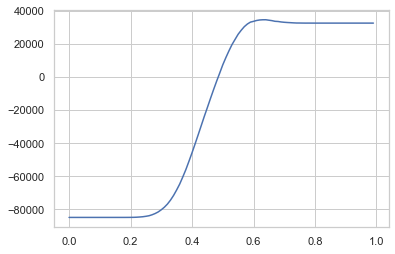

In [213]:
scores_df['gain'].plot()

In [190]:
rates = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn', 'tp', 'tn']]

In [191]:
tot_rate = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn']].sum(axis=1)

In [192]:
precision = precision_recall_df['precision']

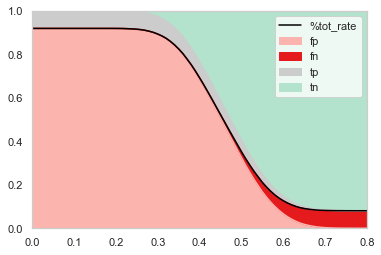

In [193]:
fig, ax = plt.subplots()
pal = ['#fbb4ae', '#e41a1c', '#cccccc', '#b3e2cd']
rates.plot(kind='area', stacked=True, ax=ax, color=pal)
tot_rate.plot(ax=ax, color='black', label='%tot_rate')
ax.set_xlim(0, 0.8)
ax.set_ylim(0, 1)
ax.legend()
plt.show()

We have to find the right balance (cost) between both case to catch an optimal threshold : fn is n times worst than fp. as it primarily depends on the famous {X, Y} parameters, leading to a damage we have no clue to compute, we don't know real value of n. <br/>
n would surely be different for revolving or high amount credits. <br/>
let's start with 7, just to see the resulting shape of a damage value.

In [194]:
damage_df = pd.DataFrame({'fp damages : unit': confusion_matrix_df['fp'],
                          'fn damages : 7x unit': 7 * confusion_matrix_df['fn']})

In [195]:
damages = (damage_df/damage_df.sum(axis=1).max())

In [196]:
tot_damage = (damage_df.sum(axis=1)/damage_df.sum(axis=1).max())

In [197]:
np.argmin(tot_damage)

57

In [207]:
scores_df.head(3)

,precision,recall,f1score,gain,custom
0.00,0.080735,1.0,0.149407,-84805,-21.772556
0.01,0.080735,1.0,0.149407,-84805,-21.772556
0.02,0.080735,1.0,0.149407,-84805,-21.772556


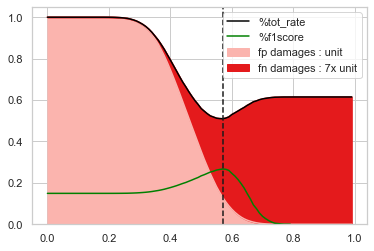

In [216]:
fig, ax = plt.subplots()
damages.plot(kind='area', stacked=True, ax=ax, color=pal)
tot_damage.plot(ax=ax, color="black", label="%tot_rate")
# scores_df['precision'].plot(ax=ax, color='green', label='%precision')
# scores_df['recall'].plot(ax=ax, color='red', label='%recall')
scores_df['f1score'].plot(ax=ax, color='green', label='%f1score')
plt.axvline(x=0.57, color='k', linestyle='--')
# ax.set_xlim(0, 0.8)
# ax.set_ylim(0, 1)
ax.legend()
plt.show()

In [152]:
print(precision_recall_df['f1score'].idxmax())
print(precision_recall_df.loc[precision_recall_df['f1score'].idxmax(), 'f1score'])

0.5700000000000001
0.267090917598615


In [177]:
# refine optimal threshold

list_tn = []
list_fp = []
list_fn = []
list_tp = []
threshold_values =[]

for i in np.arange(0,0.2,0.01) :
    temp_y_pred = threshold_pred(random_forest, X_test, threshold=i)
    tn, fp, fn, tp = confusion_matrix(y_test, temp_y_pred).ravel()
    print(tn, fp, fn, tp)
    list_tn.append(tn)
    list_fp.append(fp)
    list_fn.append(fn)
    list_tp.append(tp)
    threshold_values.append(i)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


1527 83279 38 7410


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


5353 79453 122 7326


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


11261 73545 297 7151


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


18368 66438 531 6917


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


25890 58916 808 6640


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


33099 51707 1128 6320


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


39921 44885 1513 5935


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


45935 38871 1881 5567


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


51347 33459 2268 5180


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


56106 28700 2635 4813


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


60224 24582 2990 4458


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


63915 20891 3347 4101


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


66996 17810 3668 3780


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


69604 15202 3959 3489


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


71939 12867 4263 3185


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


73879 10927 4561 2887


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


75599 9207 4838 2610


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


77010 7796 5082 2366


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.4s finished


78242 6564 5313 2135


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished


79261 5545 5519 1929


In [178]:
adj_confusion_matrix_df = pd.DataFrame({'tn' : list_tn,
                                        'fp' : list_fp,
                                        'fn' : list_fn,
                                        'tp' : list_tp},
                                        index=threshold_values) 

In [179]:
adj_rates = adj_confusion_matrix_df.divide(adj_confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn']]
adj_tot_rate = adj_confusion_matrix_df.divide(adj_confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn']].sum(axis=1)

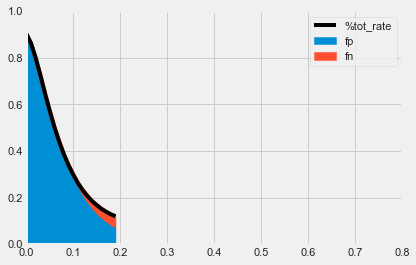

In [180]:
fig, ax = plt.subplots()
adj_rates.plot(kind='area', stacked=True, ax=ax)
adj_tot_rate.plot(ax=ax, color="black", label="%tot_rate")
ax.set_xlim(0,0.8)
ax.set_ylim(0,1)
ax.legend()
plt.show()

In [181]:
adj_damage_df = pd.DataFrame({'fp damages : unit' : adj_confusion_matrix_df['fp'],
                              'fn damages : 7x unit' : 7 * adj_confusion_matrix_df['fn']})

adj_damages = (adj_damage_df/adj_damage_df.sum(axis=1).max())

adj_tot_damage = (adj_damage_df.sum(axis=1)/adj_damage_df.sum(axis=1).max())

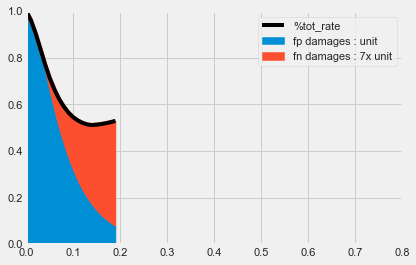

In [182]:
fig, ax = plt.subplots()
adj_damages.plot(kind='area', stacked=True, ax=ax)
adj_tot_damage.plot(ax=ax, color="black", label="%tot_rate")
ax.set_xlim(0,0.8)
ax.set_ylim(0,1)
ax.legend()
plt.show()

In [183]:
# optimal threshold
adj_damage_df.sum(axis=1).idxmin()

0.14

#### Same with class_weight

In [186]:
random_forest_weight.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


array([0.08, 0.07, 0.06, ..., 0.06, 0.03, 0.08])

In [187]:
# optimal threshold

list_tn = []
list_fp = []
list_fn = []
list_tp = []
threshold_values =[]

for i in np.arange(0,1,0.05) :
    temp_y_pred = threshold_pred(random_forest_weight, X_test, threshold=i)
    tn, fp, fn, tp = confusion_matrix(y_test, temp_y_pred).ravel()
    print(tn, fp, fn, tp)
    list_tn.append(tn)
    list_fp.append(fp)
    list_fn.append(fn)
    list_tp.append(tp)
    threshold_values.append(i)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


1450 83356 22 7426


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


36633 48173 1177 6271


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


64943 19863 3347 4101


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


76787 8019 5005 2443


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


81451 3355 6078 1370


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


83388 1418 6717 731


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


84219 587 7075 373


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


84565 241 7255 193


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


84717 89 7361 87


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


84771 35 7411 37


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


84797 9 7431 17


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


84804 2 7444 4


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


84806 0 7448 0


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


84806 0 7448 0


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


84806 0 7448 0


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


84806 0 7448 0


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


84806 0 7448 0


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


84806 0 7448 0


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


84806 0 7448 0


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


84806 0 7448 0


In [188]:
confusion_matrix_df = pd.DataFrame({'tn' : list_tn,
                                    'fp' : list_fp,
                                    'fn' : list_fn,
                                    'tp' : list_tp},
                                   index=threshold_values)

In [189]:
rates = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn']]

In [190]:
tot_rate = confusion_matrix_df.divide(confusion_matrix_df.sum(axis=1), axis=0)[['fp', 'fn']].sum(axis=1)

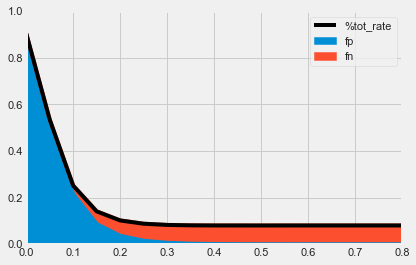

In [191]:
fig, ax = plt.subplots()
rates.plot(kind='area', stacked=True, ax=ax)
tot_rate.plot(ax=ax, color="black", label="%tot_rate")
ax.set_xlim(0,0.8)
ax.set_ylim(0,1)
ax.legend()
plt.show()

We have to find the right balance (cost) between both case to catch an optimal threshold : fn is n times worst than fp. as it primarily depends on the famous {X, Y} parameters, leading to a damage we have no clue to compute, we don't know real value of n. <br/>
n would surely be different for revolving or high amount credits. <br/>
let's start with 7, just to see the resulting shape of a damage value.

In [192]:
damage_df = pd.DataFrame({'fp damages : unit' : confusion_matrix_df['fp'],
                          'fn damages : 7x unit' : 7 * confusion_matrix_df['fn']})

In [193]:
damages = (damage_df/damage_df.sum(axis=1).max())

In [194]:
tot_damage = (damage_df.sum(axis=1)/damage_df.sum(axis=1).max())

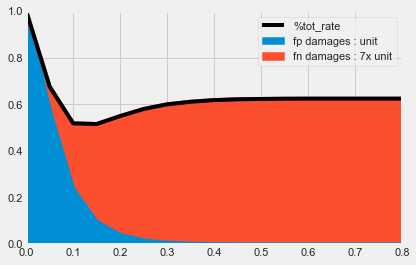

In [195]:
fig, ax = plt.subplots()
damages.plot(kind='area', stacked=True, ax=ax)
tot_damage.plot(ax=ax, color="black", label="%tot_rate")
ax.set_xlim(0,0.8)
ax.set_ylim(0,1)
ax.legend()
plt.show()

#### Testing Domain Features

Now we can test the domain features we made by hand.

In [ ]:
# same with so called "domain" features
if 'TARGET' in app_train:
    X_domain = app_train_domain.drop(columns = ['TARGET'])
else:
    X_domain = app_train_domain.copy()
y_domain = app_train_domain['TARGET']
    
# Feature names
domain_features_names = list(X_domain.columns)


# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit-transform training dataset
X_domain = imputer.fit_transform(X_domain)

# Repeat with the scaler
X_domain = scaler.fit_transform(X_domain)

# Split data into train and test set (stratify by target)
X_dom_train, X_dom_test, y_dom_train, y_dom_test = train_test_split(X_domain, y_domain, stratify=y_domain, test_size=0.3, random_state=42)


print('Training data shape: ', X_dom_train.shape)
print('Testing data shape: ', X_dom_test.shape)

print('Labels train data shape: ', y_dom_train.shape)
print('Labels test data shape: ', y_dom_test.shape)

In [ ]:
# Make the random forest classifier
random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest_domain.fit(X_dom_train, y_dom_train)

# Extract feature importances
feature_importance_domain_values = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_domain_values})

# Make predictions on the test data
ran_for_dom_pred = random_forest_domain.predict_proba(X_dom_test)[:, 1]

__Random Forest with Basic FE and Application df only score around AUC 0.71__

#### Testing transparency 

Now we can test the removal of ext_ features as well as SK ID

In [ ]:
# same with so called "domain" features
app_transp = app_train_domain.drop(columns = ['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])


if 'TARGET' in app_train:
    X_transp = app_transp.drop(columns = ['TARGET'])
else:
    X_transp = app_transp.copy()
y_transp = app_transp['TARGET']
    
# Feature names
transp_features_names = list(X_transp.columns)


# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit-transform training dataset
X_transp = imputer.fit_transform(X_transp)

# Repeat with the scaler
X_transp = scaler.fit_transform(X_transp)

# Split data into train and test set (stratify by target)
X_transp_train, X_transp_test, y_transp_train, y_transp_test = train_test_split(X_transp, y_transp, stratify=y_transp, test_size=0.3, random_state=42)


print('Training data shape: ', X_transp_train.shape)
print('Testing data shape: ', X_transp_test.shape)

print('Labels train data shape: ', y_transp_train.shape)
print('Labels test data shape: ', y_transp_test.shape)

In [ ]:
# Make the random forest classifier
random_forest_transp = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest_transp.fit(X_transp_train, y_transp_train)

# Extract feature importances
feature_importance_transp_values = random_forest_transp.feature_importances_
feature_importances_transp = pd.DataFrame({'feature': transp_features_names, 'importance': feature_importance_transp_values})

# Make predictions on the test data
ran_for_transp_pred = random_forest_transp.predict_proba(X_transp_test)[:, 1]

In [ ]:
auc_scor = roc_auc_score(y_transp_test, ran_for_transp_pred)
print("AUC score: ", auc_scor)

print("Confusion matrix: ")
print(confusion_matrix(y_transp_test, ran_for_dom_pred.round(), normalize=None))

print("Accuracy score: ", accuracy_score(y_transp_test, ran_for_dom_pred.round()))
print("Recall score: ", recall_score(y_transp_test, ran_for_dom_pred.round()))
print("F1-score: ", f1_score(y_transp_test, ran_for_dom_pred.round()))

__Random Forest for transparency ! with Basic FE and Application df only score around AUC 0.65__

## Model Interpretation: Feature Importances

As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. Given the correlations we saw in the exploratory data analysis, we should expect that the most important features are the `EXT_SOURCE` and the `DAYS_BIRTH`. We may use these feature importances as a method of dimensionality reduction in future work.

In [44]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 12))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:30]))), 
            df['importance_normalized'].head(30), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:30]))))
    ax.set_yticklabels(df['feature'].head(30))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

4:66: W291 trailing whitespace
5:1: W293 blank line contains whitespace
9:1: W293 blank line contains whitespace
12:1: W293 blank line contains whitespace
13:80: E501 line too long (84 > 79 characters)
13:85: W291 trailing whitespace
16:1: W293 blank line contains whitespace
18:48: E251 unexpected spaces around keyword / parameter equals
18:50: E251 unexpected spaces around keyword / parameter equals
19:1: W293 blank line contains whitespace
24:23: E251 unexpected spaces around keyword / parameter equals
24:25: E251 unexpected spaces around keyword / parameter equals
26:1: W293 blank line contains whitespace
28:49: W291 trailing whitespace
29:50: W291 trailing whitespace
30:18: E251 unexpected spaces around keyword / parameter equals
30:20: E251 unexpected spaces around keyword / parameter equals
30:40: E251 unexpected spaces around keyword / parameter equals
30:42: E251 unexpected spaces around keyword / parameter equals
31:1: W293 blank line contains whitespace
35:1: W293 blank line 

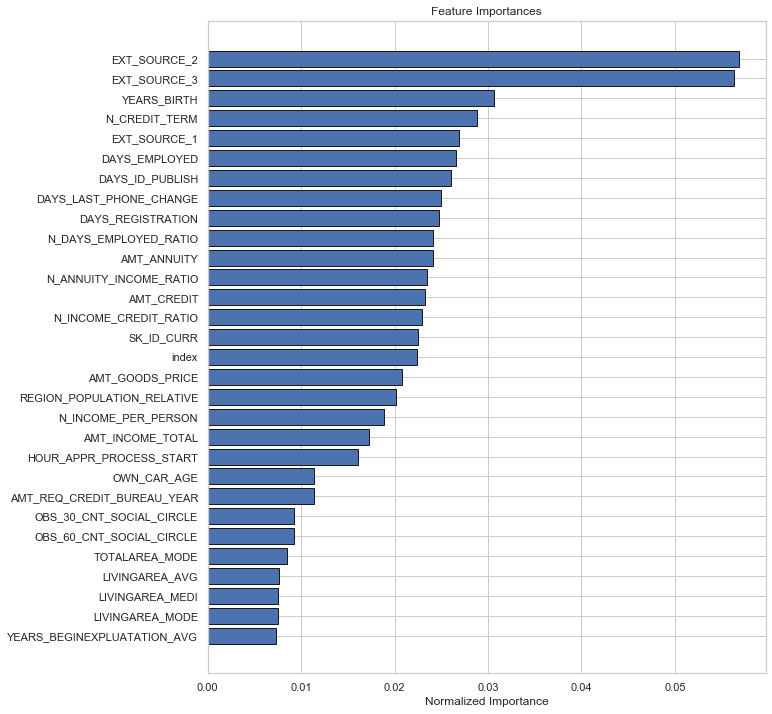

In [45]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

As expected, the most important features are those dealing with `EXT_SOURCE` and `DAYS_BIRTH`. We see that there are only a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.) Feature importances are not the most sophisticated method to interpret a model or perform dimensionality reduction, but they let us start to understand what factors our model takes into account when it makes predictions. 

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

We see that all four of our hand-engineered features made it into the top 15 most important! This should give us confidence that our domain knowledge was at least partially on track.

In [ ]:
feature_importances_transp_sorted = plot_feature_importances(feature_importances_transp)

# Just for Fun: Light Gradient Boosting Machine

Now (if you want, this part is entirely optional) we can step off the deep end and use a real machine learning model: the [gradient boosting machine](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/) using the [LightGBM library](http://lightgbm.readthedocs.io/en/latest/Quick-Start.html)! The Gradient Boosting Machine is currently the leading model for learning on structured datasets (especially on Kaggle) and we will probably need some form of this model to do well in the competition. Don't worry, even if this code looks intimidating, it's just a series of small steps that build up to a complete model. I added this code just to show what may be in store for this project, and because it gets us a slightly better score on the leaderboard. In future notebooks we will see how to work with more advanced models (which mostly means adapting existing code to make it work better), feature engineering, and feature selection. See you in the next notebook!  

In [ ]:
import lightgbm as lgb


def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

## Remedy imbalanced data with upsampling using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('baseline_lgb.csv', index = False)

This submission should score about 0.735 on the leaderboard. We will certainly best that in future work! 

In [ ]:
app_train_domain['TARGET'] = train_labels

# Test the domain knolwedge features
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

In [ ]:
fi_sorted = plot_feature_importances(fi_domain)

Again, we see tha some of our features made it into the most important. Going forward, we will need to think about whatother domain knowledge features may be useful for this problem (or we should consult someone who knows more about the financial industry! 

In [ ]:
submission_domain.to_csv('baseline_lgb_domain_features.csv', index = False)

This model scores about 0.754 when submitted to the public leaderboard indicating that the domain features do improve the performance! [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is going to be a critical part of this competition (as it is for all machine learning problems)!